# Supervised Machine Learning competition
## Multi-class classification

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from flaml import AutoML
from catboost import CatBoostClassifier, Pool

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

Import data and store in DataFrames

In [3]:
df_feat_test = pd.read_csv('../data/raw/features_test.csv')
df_targ_train = pd.read_csv('../data/raw/target_train.csv')
df_feat_train = pd.read_csv('../data/raw/features_train.csv')

In [4]:
X_test_raw = df_feat_test.copy()
X_train_raw = df_feat_train.copy()
y_train = df_targ_train['Expected']

X_train = X_train_raw.drop(columns = ['Id'])
X_test = X_test_raw.drop(columns = ['Id'])

Data inspection

In [5]:
X_test.shape, X_train.shape, y_train.shape

((20000, 120), (10000, 120), (10000,))

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 120 entries, 0 to 119
dtypes: float64(120)
memory usage: 9.2 MB


In [7]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
count,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.000206e+00,1.653294,1.323895e+01,1.631063,1.004520e+00,1.011949e+00,0.520059,1.657632,-0.002513,1.671704,...,1.648705,0.497571,0.493227,1.635187,-0.000071,-0.026737,0.013010,1.620603,0.503886,1.667950
std,1.423822e+00,2.278088,1.870323e+01,2.040002,1.409997e+00,1.444751e+00,31.791384,2.116264,10.060025,2.251833,...,2.188790,0.285955,0.290153,1.975617,0.997596,10.082855,9.968787,2.117979,0.285662,2.203032
min,1.282517e-08,0.024358,7.274511e-07,0.020518,3.379589e-11,1.348884e-07,-129.141171,0.019514,-37.427526,0.028163,...,0.022037,0.000128,0.000217,0.016691,-3.885360,-34.580159,-40.925480,0.016396,0.000139,0.029379
25%,1.040056e-01,0.509503,1.318718e+00,0.512428,1.042731e-01,1.005381e-01,-21.037225,0.507242,-6.698098,0.512798,...,0.510389,0.252094,0.241741,0.511563,-0.677989,-6.804569,-6.904905,0.504073,0.260493,0.513686
50%,4.602140e-01,0.995946,6.109321e+00,0.994325,4.558152e-01,4.490724e-01,0.351341,0.998968,0.081728,0.996833,...,0.990977,0.496045,0.488491,0.999822,-0.006377,-0.109698,0.155250,1.002604,0.503294,1.003636
75%,1.295762e+00,1.943914,1.758705e+01,1.933788,1.339252e+00,1.336866e+00,21.714889,1.982386,6.818884,1.984666,...,1.944777,0.744041,0.747421,1.988738,0.669345,6.765366,6.820834,1.932612,0.748390,1.941041
max,1.601254e+01,72.033830,2.681004e+02,33.933547,1.684319e+01,1.812245e+01,118.399310,37.265489,38.392229,45.191073,...,36.698799,0.999973,0.999895,26.936000,3.737129,36.371289,34.679957,44.943499,0.999985,45.467996


In [8]:
X_train.isnull().sum().unique()

array([0], dtype=int64)

c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


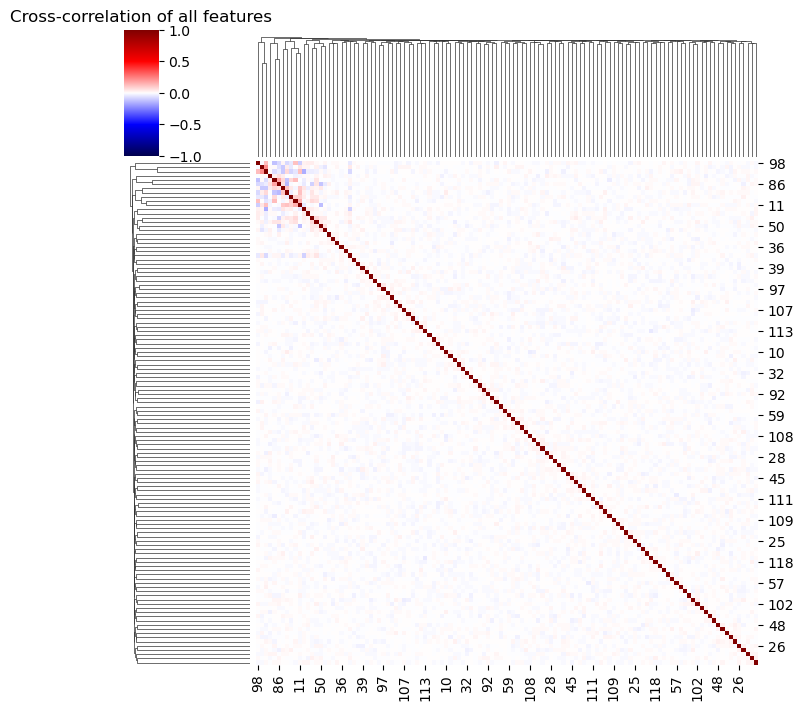

In [14]:
sns.clustermap(X_train.corr(), cmap = "seismic", figsize = (7,7), vmin = -1, vmax = 1)
plt.title('Cross-correlation of all features')
plt.show()

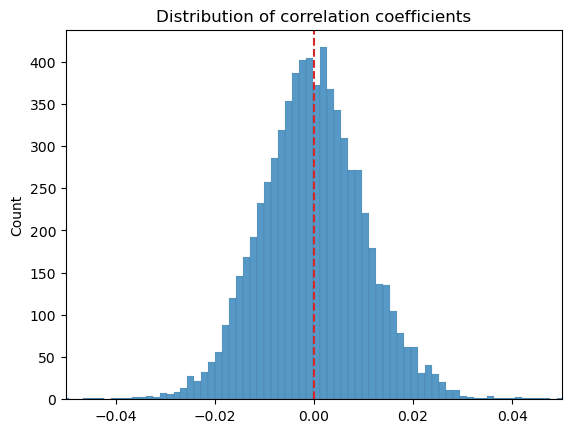

In [10]:
sns.histplot(X_train.corr().unstack().sort_values(ascending=False).drop_duplicates())
plt.xlim(-0.05, 0.05)
plt.axvline(0, color = 'C3', linestyle = '--')
plt.title('Distribution of correlation coefficients')
plt.show()

The majority of the features have close to 0 correlation with each other.

## First use a Logistic Regression model as baseline

In [11]:
log_reg = LogisticRegression(random_state=23, solver='liblinear')

cv_log_reg = cross_val_score(log_reg, X_train, y_train, cv = 5, scoring='f1_macro')
print(cv_log_reg)
print(np.mean(cv_log_reg))

[0.47943215 0.4771819  0.48017851 0.47903136 0.47409433]
0.4779836520361115


In [12]:
log_reg.fit(X_train, y_train)
pred_log_reg = log_reg.predict(X_train)
print(confusion_matrix(y_train, pred_log_reg))
print(classification_report(y_train, pred_log_reg))

fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix(y_train, pred_log_reg), annot=True, vmin=0, ax=ax)
plt.show()

[[1792  797  752]
 [ 814 1820  660]
 [1098  854 1413]]
              precision    recall  f1-score   support

           0       0.48      0.54      0.51      3341
           1       0.52      0.55      0.54      3294
           2       0.50      0.42      0.46      3365

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



Logistic regression performs very poorly on this dataset, let's try to find a better model!

## Use AutoML from FLAML to search for most promising ML model class

In [31]:
automl = AutoML()

automl_settings = {
                    "time_budget": 300, # 5 min. to find best model
                    "metric": 'macro_f1',
                    "task": 'classification',
                    "log_file_name": 'mylog.log',
                    "eval_method": 'cv',
                    "n_splits": 5       
                    }

In [32]:
automl.fit(
            X_train = X_train,
            y_train = y_train.values,
            **automl_settings,
            verbose=1
            )

c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [45]:
print(automl.best_estimator)
print(automl.best_config)
best_f1_macro = 1 - automl.best_loss
print('Best F1_macro score:', best_f1_macro )

catboost
{'early_stopping_rounds': 10, 'learning_rate': 0.09999999999999996, 'n_estimators': 180}
Best F1_macro score: 0.6183200233189117


Catboost seems to be the most promising model and performs much better than logistic regression!

### Use a CatBoostClassifier for feature selection

In [29]:
model_Cat = CatBoostClassifier(
                                early_stopping_rounds = 10,
                                learning_rate = 0.1,
                                n_estimators = 180,
                                thread_count = -1,
                                verbose = False,
                                random_seed = 23
                                )

In [33]:
model_Cat.fit(X_train, y_train)

[[2585  393  363]
 [ 357 2584  353]
 [ 464  359 2542]]
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      3341
           1       0.77      0.78      0.78      3294
           2       0.78      0.76      0.77      3365

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



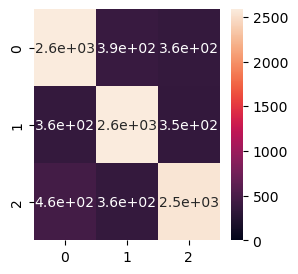

In [40]:
pred_model_Cat = model_Cat.predict(X_train)
print(confusion_matrix(y_train, pred_model_Cat))
print(classification_report(y_train, pred_model_Cat))

fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix(y_train, pred_model_Cat), annot=True, vmin=0, ax=ax)
plt.show()

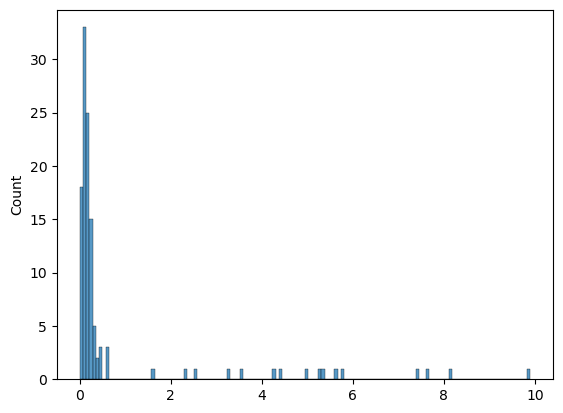

In [41]:
list_feat_imp = model_Cat.get_feature_importance(data = Pool(X_train, label=y_train))
sns.histplot(list_feat_imp);

Most features have a feature importance score of close to zero! Let's select only those features that have a score > 1!

In [45]:
len(list_feat_imp[list_feat_imp<1])

104

In [46]:
len(list_feat_imp[list_feat_imp>1])

16

We are left with 16 relevant features, we eliminate all the other ones

In [48]:
feats = model_Cat.select_features(
                                    X_train,
                                    y_train,
                                    features_for_select = list(range(120)),
                                    num_features_to_select = 16,
                                    verbose=1,
                                    train_final_model=False,
                                    )

Step #1 out of 1
0:	learn: 1.0868056	total: 81.9ms	remaining: 14.7s
1:	learn: 1.0751241	total: 147ms	remaining: 13.1s
2:	learn: 1.0644163	total: 204ms	remaining: 12s
3:	learn: 1.0545905	total: 258ms	remaining: 11.3s
4:	learn: 1.0454149	total: 339ms	remaining: 11.9s
5:	learn: 1.0398511	total: 405ms	remaining: 11.7s
6:	learn: 1.0310068	total: 491ms	remaining: 12.1s
7:	learn: 1.0235386	total: 575ms	remaining: 12.4s
8:	learn: 1.0173164	total: 634ms	remaining: 12.1s
9:	learn: 1.0120345	total: 692ms	remaining: 11.8s
10:	learn: 1.0068491	total: 755ms	remaining: 11.6s
11:	learn: 1.0025513	total: 824ms	remaining: 11.5s
12:	learn: 0.9995746	total: 887ms	remaining: 11.4s
13:	learn: 0.9935697	total: 958ms	remaining: 11.4s
14:	learn: 0.9918069	total: 1.02s	remaining: 11.3s
15:	learn: 0.9847384	total: 1.09s	remaining: 11.2s
16:	learn: 0.9801788	total: 1.15s	remaining: 11s
17:	learn: 0.9770810	total: 1.23s	remaining: 11s
18:	learn: 0.9731869	total: 1.29s	remaining: 11s
19:	learn: 0.9694724	total: 1.3

In [49]:
# Select best features
X_train_red = X_train.iloc[:,feats['selected_features']]
X_train_red.shape

(10000, 16)

## Use another round of AutoML to find the best model for the reduced dataset

In [50]:
automl_red = AutoML()

automl_settings_red = {
                    "time_budget": 2400, # 40 min. to find best model
                    "metric": 'macro_f1',
                    "task": 'classification',
                    "log_file_name": 'mylog.log',
                    "eval_method": 'cv',
                    "n_splits": 5       
                    }

automl_red.fit(
                X_train = X_train_red,
                y_train = y_train.values,
                **automl_settings_red,
                verbose=0
                )

c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

In [53]:
print(automl_red.best_estimator)
print(automl_red.best_config)
best_f1_macro = 1 - automl_red.best_loss
print('Best F1_macro score:', best_f1_macro )

catboost
Best F1_macro score: 0.6858188379086645


In [57]:
automl_red.best_config

{'early_stopping_rounds': 19,
 'learning_rate': 0.029251114134839495,
 'n_estimators': 1457}

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      3341
           1       0.87      0.87      0.87      3294
           2       0.87      0.85      0.86      3365

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



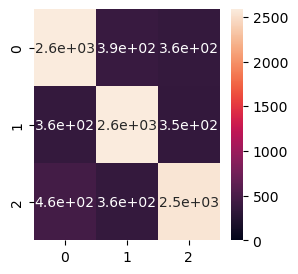

In [52]:
pred_automl_red = automl_red.predict(X_train_red)
cf = confusion_matrix(y_train, pred_automl_red)
print(classification_report(y_train, pred_automl_red))

fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix(y_train, pred_model_Cat), annot=True, vmin=0, ax=ax)
plt.show()

## Train another CatBoostClassifer with reduced features

As the AutoML approach suggests that a high number of estimators is useful, we increase the n_estimator parameter to 5000.

In [74]:
model_Cat_red = CatBoostClassifier(
                                early_stopping_rounds = 20,
                                learning_rate = 0.025,
                                n_estimators = 5000,
                                thread_count = -1,
                                verbose = False,
                                random_seed = 23
                                )

In [75]:
cv_model_Cat_red = cross_val_score(model_Cat_red, X_train_red, y_train, cv = 5, scoring='f1_macro')
print(cv_model_Cat_red)
print(np.mean(cv_model_Cat_red))

[0.69907774 0.6805571  0.68546775 0.70873798 0.70417427]
0.6956029692728389


In [76]:
model_Cat_red.fit(X_train_red, y_train)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3341
           1       0.95      0.96      0.96      3294
           2       0.96      0.95      0.95      3365

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



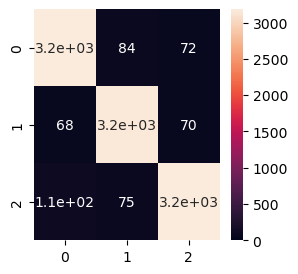

In [77]:
pred_model_Cat_red = model_Cat_red.predict(X_train_red)
cf = confusion_matrix(y_train, pred_model_Cat_red)
print(classification_report(y_train, pred_model_Cat_red))

fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix(y_train, pred_model_Cat_red), annot=True, vmin=0, ax=ax)
plt.show()

In [67]:
X_test_red = X_test.iloc[:,feats['selected_features']]
X_test_red.shape

(20000, 16)

In [78]:
y_pred_Cat_red = model_Cat_red.predict(X_test_red)

In [82]:
df_pred_Cat_red = pd.DataFrame()
df_pred_Cat_red['Id']=X_test_raw['Id']
df_pred_Cat_red.set_index('Id', inplace=True)
df_pred_Cat_red['Predicted'] = y_pred_Cat_red2.ravel()

df_pred_Cat_red.to_csv('../data/raw/df_pred_Cat_red.csv')

In [83]:
df_pred_Cat_red2

,Predicted
Id,
0,2
1,0
2,1
3,2
4,1
...,...
19995,0
19996,1
19997,2


## Try out if an FLAML AutoML ensemble approach yields even better results

In [84]:
automl_ens = AutoML()

automl_settings_ens = {
                    "time_budget": 3600, # 40 min. to find best model
                    "metric": 'macro_f1',
                    "task": 'classification',
                    "log_file_name": 'mylog.log',
                    "eval_method": 'cv',
                    "n_splits": 5       
                    }

automl_ens.fit(
                X_train = X_train_red,
                y_train = y_train.values,
                ensemble = True,
                **automl_settings_red,
                verbose = 0,
                )

[flaml.automl.logger: 03-14 20:12:31] {1680} INFO - task = classification
[flaml.automl.logger: 03-14 20:12:31] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 03-14 20:12:31] {1789} INFO - Minimizing error metric: 1-macro_f1
[flaml.automl.logger: 03-14 20:12:31] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 03-14 20:12:31] {2219} INFO - iteration 0, current learner lgbm


[flaml.automl.logger: 03-14 20:12:31] {2345} INFO - Estimated sufficient time budget=3570s. Estimated necessary time budget=88s.
[flaml.automl.logger: 03-14 20:12:31] {2392} INFO -  at 0.4s,	estimator lgbm's best error=0.5307,	best estimator lgbm's best error=0.5307
[flaml.automl.logger: 03-14 20:12:31] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 03-14 20:12:31] {2392} INFO -  at 0.7s,	estimator lgbm's best error=0.5294,	best estimator lgbm's best error=0.5294
[flaml.automl.logger: 03-14 20:12:31] {2219} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 03-14 20:12:32] {2392} INFO -  at 1.0s,	estimator lgbm's best error=0.5294,	best estimator lgbm's best error=0.5294
[flaml.automl.logger: 03-14 20:12:32] {2219} INFO - iteration 3, current learner lgbm
[flaml.automl.logger: 03-14 20:12:32] {2392} INFO -  at 1.3s,	estimator lgbm's best error=0.5110,	best estimator lgbm's best error=0.5110
[flaml.automl.logger: 03-14 20:12:32] {2219} INFO - iteration

c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:35:45] {2392} INFO -  at 1394.5s,	estimator lrl1's best error=0.5290,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:35:45] {2219} INFO - iteration 148, current learner extra_tree


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:36:05] {2392} INFO -  at 1414.7s,	estimator extra_tree's best error=0.3550,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:36:05] {2219} INFO - iteration 149, current learner rf
[flaml.automl.logger: 03-14 20:36:51] {2392} INFO -  at 1460.7s,	estimator rf's best error=0.3719,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:36:51] {2219} INFO - iteration 150, current learner extra_tree
[flaml.automl.logger: 03-14 20:36:58] {2392} INFO -  at 1467.4s,	estimator extra_tree's best error=0.3550,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:36:58] {2219} INFO - iteration 151, current learner rf
[flaml.automl.logger: 03-14 20:37:14] {2392} INFO -  at 1483.2s,	estimator rf's best error=0.3719,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:37:14] {2219} INFO - iteration 152, current learner extra_tree
[flaml.automl.logger: 03-14 20:37:35] {2392} INFO - 

c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:37:38] {2392} INFO -  at 1507.6s,	estimator lrl1's best error=0.5290,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:37:38] {2219} INFO - iteration 154, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[flaml.automl.logger: 03-14 20:37:42] {2392} INFO -  at 1511.1s,	estimator lrl1's best error=0.5290,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:37:42] {2219} INFO - iteration 155, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[flaml.automl.logger: 03-14 20:37:45] {2392} INFO -  at 1514.5s,	estimator lrl1's best error=0.5289,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:37:45] {2219} INFO - iteration 156, current learner lgbm


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:38:07] {2392} INFO -  at 1536.2s,	estimator lgbm's best error=0.3390,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:38:07] {2219} INFO - iteration 157, current learner rf
[flaml.automl.logger: 03-14 20:38:40] {2392} INFO -  at 1569.6s,	estimator rf's best error=0.3719,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:38:40] {2219} INFO - iteration 158, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:38:43] {2392} INFO -  at 1572.8s,	estimator lrl1's best error=0.5289,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:38:43] {2219} INFO - iteration 159, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[flaml.automl.logger: 03-14 20:38:47] {2392} INFO -  at 1576.6s,	estimator lrl1's best error=0.5289,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:38:47] {2219} INFO - iteration 160, current learner extra_tree


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:38:54] {2392} INFO -  at 1583.4s,	estimator extra_tree's best error=0.3550,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:38:54] {2219} INFO - iteration 161, current learner xgb_limitdepth
[flaml.automl.logger: 03-14 20:39:52] {2392} INFO -  at 1641.6s,	estimator xgb_limitdepth's best error=0.3235,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:39:52] {2219} INFO - iteration 162, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:39:56] {2392} INFO -  at 1645.3s,	estimator lrl1's best error=0.5286,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:39:56] {2219} INFO - iteration 163, current learner extra_tree


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:40:00] {2392} INFO -  at 1649.5s,	estimator extra_tree's best error=0.3550,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:40:00] {2219} INFO - iteration 164, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:40:04] {2392} INFO -  at 1653.1s,	estimator lrl1's best error=0.5286,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:40:04] {2219} INFO - iteration 165, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[flaml.automl.logger: 03-14 20:40:07] {2392} INFO -  at 1656.8s,	estimator lrl1's best error=0.5286,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:40:07] {2219} INFO - iteration 166, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[flaml.automl.logger: 03-14 20:40:11] {2392} INFO -  at 1660.4s,	estimator lrl1's best error=0.5286,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:40:11] {2219} INFO - iteration 167, current learner extra_tree


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:40:44] {2392} INFO -  at 1693.7s,	estimator extra_tree's best error=0.3550,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:40:44] {2219} INFO - iteration 168, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:40:48] {2392} INFO -  at 1697.5s,	estimator lrl1's best error=0.5286,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:40:48] {2219} INFO - iteration 169, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[flaml.automl.logger: 03-14 20:40:52] {2392} INFO -  at 1701.3s,	estimator lrl1's best error=0.5286,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:40:52] {2219} INFO - iteration 170, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[flaml.automl.logger: 03-14 20:40:56] {2392} INFO -  at 1705.3s,	estimator lrl1's best error=0.5286,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:40:56] {2219} INFO - iteration 171, current learner rf


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:41:17] {2392} INFO -  at 1726.2s,	estimator rf's best error=0.3657,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:41:17] {2219} INFO - iteration 172, current learner lgbm
[flaml.automl.logger: 03-14 20:41:44] {2392} INFO -  at 1753.3s,	estimator lgbm's best error=0.3370,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:41:44] {2219} INFO - iteration 173, current learner lgbm
[flaml.automl.logger: 03-14 20:42:22] {2392} INFO -  at 1791.1s,	estimator lgbm's best error=0.3370,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:42:22] {2219} INFO - iteration 174, current learner extra_tree
[flaml.automl.logger: 03-14 20:42:31] {2392} INFO -  at 1799.9s,	estimator extra_tree's best error=0.3550,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:42:31] {2219} INFO - iteration 175, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:42:34] {2392} INFO -  at 1803.5s,	estimator lrl1's best error=0.5286,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:42:34] {2219} INFO - iteration 176, current learner xgb_limitdepth


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:45:44] {2392} INFO -  at 1993.9s,	estimator xgb_limitdepth's best error=0.3235,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:45:44] {2219} INFO - iteration 177, current learner catboost
[flaml.automl.logger: 03-14 20:46:22] {2392} INFO -  at 2031.8s,	estimator catboost's best error=0.3169,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:46:22] {2219} INFO - iteration 178, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:46:27] {2392} INFO -  at 2036.0s,	estimator lrl1's best error=0.5286,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:46:27] {2219} INFO - iteration 179, current learner xgb_limitdepth


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:47:52] {2392} INFO -  at 2121.2s,	estimator xgb_limitdepth's best error=0.3235,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:47:52] {2219} INFO - iteration 180, current learner catboost
[flaml.automl.logger: 03-14 20:49:13] {2392} INFO -  at 2202.5s,	estimator catboost's best error=0.3169,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:49:13] {2219} INFO - iteration 181, current learner xgb_limitdepth
[flaml.automl.logger: 03-14 20:51:31] {2392} INFO -  at 2340.1s,	estimator xgb_limitdepth's best error=0.3235,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:51:31] {2219} INFO - iteration 182, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 20:51:34] {2392} INFO -  at 2343.5s,	estimator lrl1's best error=0.5286,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:51:34] {2219} INFO - iteration 183, current learner lrl1


c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[flaml.automl.logger: 03-14 20:51:38] {2392} INFO -  at 2347.0s,	estimator lrl1's best error=0.5286,	best estimator catboost's best error=0.3169
[flaml.automl.logger: 03-14 20:51:38] {2526} INFO - [('catboost', {'early_stopping_rounds': 13, 'learning_rate': 0.04171721859304757, 'n_estimators': 860, 'thread_count': -1, 'verbose': False, 'random_seed': 10242048}), ('xgb_limitdepth', {'n_jobs': -1, 'n_estimators': 832, 'max_depth': 10, 'min_child_weight': 0.20868344379243448, 'learning_rate': 0.07093075883678267, 'subsample': 0.8413048297641477, 'colsample_bylevel': 0.26735884807331084, 'colsample_bytree': 0.5755451734871456, 'reg_alpha': 0.027208245582538794, 'reg_lambda': 2.07727869274457, 'verbosity': 0}), ('lgbm', {'n_jobs': -1, 'n_estimators': 185, 'num_leaves': 49, 'min_child_samples': 2, 'learning_rate': 0.18465941718556778, 'colsample_bytree': 0.8366461584896899, 'reg_alpha': 0.006311706639004055, 'reg_lambda': 0.006993008315649459, 'max_bin': 1023, 'verbose': -1}), ('extra_tree',

c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 03-14 21:01:46] {2575} INFO - ensemble: StackingClassifier(estimators=[('catboost',
                                <flaml.automl.model.CatBoostEstimator object at 0x000001C454420CD0>),
                               ('xgb_limitdepth',
                                <flaml.automl.model.XGBoostLimitDepthEstimator object at 0x000001C45B5D47D0>),
                               ('lgbm',
                                <flaml.automl.model.LGBMEstimator object at 0x000001C45B5D6950>),
                               ('extra_tree',
                                <flaml.automl.model.ExtraTreesEstimator object at 0x000001C45B5D7090>),
                               ('xgboost',
                                <flaml.automl.model.XGBoostSklearnEstimator object at 0x000001C45B5D7C90>),
                               ('rf',
                                <flaml.automl.model.RandomForestEstimator object at 0x000001C450711590>),
                               ('lrl1',
        

c:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [85]:
automl_ens.best_estimator

'catboost'

In [87]:
best_f1_macro = 1 - automl_ens.best_loss
print('Best F1_macro score:', best_f1_macro )

Best F1_macro score: 0.6831346047057363


In [88]:
automl_ens.model

StackingClassifier(estimators=[('catboost',
                                <flaml.automl.model.CatBoostEstimator object at 0x000001C454420CD0>),
                               ('xgb_limitdepth',
                                <flaml.automl.model.XGBoostLimitDepthEstimator object at 0x000001C45B5D47D0>),
                               ('lgbm',
                                <flaml.automl.model.LGBMEstimator object at 0x000001C45B5D6950>),
                               ('extra_tree',
                                <flaml.automl.model.ExtraTreesEstimator object at 0x000001C45B5D7090>),
                               ('xgboost',
                                <flaml.automl.model.XGBoostSklearnEstimator object at 0x000001C45B5D7C90>),
                               ('rf',
                                <flaml.automl.model.RandomForestEstimator object at 0x000001C450711590>),
                               ('lrl1',
                                <flaml.automl.model.LRL1Classifier object at 0x000001C4507111D0>)],
                   n_jobs=1, passthrough=True)

              precision    recall  f1-score   support

           0       0.58      0.47      0.52      3341
           1       0.54      0.63      0.58      3294
           2       0.53      0.55      0.54      3365

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



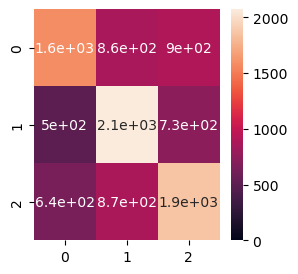

In [91]:
pred_automl_ens = automl_ens.model.predict(X_train_red)
cf = confusion_matrix(y_train, pred_automl_ens)
print(classification_report(y_train, pred_automl_ens))

fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix(y_train, pred_automl_ens), annot=True, vmin=0, ax=ax)
plt.show()

The ensemble model is much worse than the previous Catboost model

## Finetune CatBoost using GridSearchCV

In [98]:
from sklearn.model_selection import GridSearchCV

catboost_tune = CatBoostClassifier(random_seed = 23,
                                   verbose = False,
                                   thread_count = -1)
                                  
grid_search = {
            #'early_stopping_rounds': [10, 20],
            #'min_data_in_leaf': [50, 100],
            'learning_rate': [0.01, 0.02],
            'n_estimators': [5000, 7500]
            }

grid_search_obj = GridSearchCV(
                                estimator = catboost_tune,
                                param_grid = grid_search,
                                scoring = 'f1_macro',
                                cv = 3,
                                verbose = 2,
                                n_jobs = -1
                                )

In [99]:
grid_search_obj.fit(X_train_red, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001C4031D0390>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02],
                         'n_estimators': [5000, 7500]},
             scoring='f1_macro', verbose=2)

[[3129  111  101]
 [  96 3106   92]
 [ 144  101 3120]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3341
           1       0.94      0.94      0.94      3294
           2       0.94      0.93      0.93      3365

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



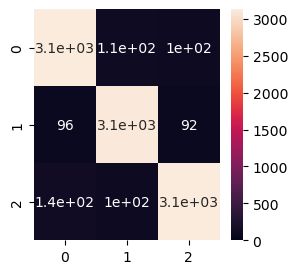

In [102]:
pred_cat_grid = grid_search_obj.best_estimator_.predict(X_train_red)
print(classification_report(y_train, pred_cat_grid))

fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix(y_train, pred_cat_grid), annot=True, vmin=0, ax=ax)
plt.show()

In [101]:
pd.set_option('display.max_colwidth', None)

cv_result_df = pd.DataFrame({
    'Model Rank': grid_search_obj.cv_results_['rank_test_score'],
    'Model Hyperparams': grid_search_obj.cv_results_['params'],
    'Avg CV F1-macro': grid_search_obj.cv_results_['mean_test_score'],
    'Std Dev CV F1-macro': grid_search_obj.cv_results_['std_test_score'],
    'CV Fold 1 F1-macro': grid_search_obj.cv_results_['split0_test_score'],
    'CV Fold 2 F1-macro': grid_search_obj.cv_results_['split1_test_score'],
    'CV Fold 3 F1-macro': grid_search_obj.cv_results_['split2_test_score']
})

cv_result_df.sort_values(by=['Model Rank'], ascending=True)

,Model Rank,Model Hyperparams,Avg CV F1-macro,Std Dev CV F1-macro,CV Fold 1 F1-macro,CV Fold 2 F1-macro,CV Fold 3 F1-macro
1,1,"{'learning_rate': 0.01, 'n_estimators': 7500}",0.694275,0.008199,0.684151,0.694442,0.704232
3,2,"{'learning_rate': 0.02, 'n_estimators': 7500}",0.691162,0.008216,0.679963,0.694082,0.699442
0,3,"{'learning_rate': 0.01, 'n_estimators': 5000}",0.690981,0.008110,0.682370,0.688725,0.701848
2,4,"{'learning_rate': 0.02, 'n_estimators': 5000}",0.689705,0.006011,0.681720,0.691172,0.696222


No performance improvement to model_Cat_red

## Finetune CatBoost via Bayesian hyperparameter tuning using hyperopt

In [103]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [105]:
space = {
        'learning_rate':  hp.choice('learning_rate', [0.0075, 0.01, 0.015]),
        'n_estimators': hp.choice('n_estimators', [5000, 7500, 10000]),
        }

def objective(space):
    cat_model_opt = CatBoostClassifier(
                                        learning_rate = space['learning_rate'],
                                        n_estimators = space['n_estimators'],
                                        min_data_in_leaf = 50,
                                        early_stopping_rounds = 20,
                                        random_seed = 23,
                                        verbose = False,
                                        thread_count = -1
                                        )
    
   
       
    f1 = cross_val_score(cat_model_opt, X_train_red, y_train, cv=3, scoring='f1_macro').mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, # Tree parzen estimator
            max_evals=5,
            trials=trials)
best

100%|██████████| 5/5 [21:22<00:00, 256.42s/trial, best loss: -0.693890739048095]


{'learning_rate': 1, 'n_estimators': 2}

In [108]:
#depth = {0: 6}
lrate = {0: 0.0075, 1: 0.01, 2:0.015}
n_est = {0: 5000, 1:7500, 2:10000}
#l2_reg = {0: 10, 1: 30, 2: 100}

optimal_cat = CatBoostClassifier(
                                  learning_rate = lrate[best['learning_rate']],
                                  #l2_leaf_reg = l2_reg[best['l2_leaf_reg']],
                                  n_estimators = n_est[best['n_estimators']],
                                  #min_data_in_leaf = 50,
                                  #early_stopping_rounds = 20,
                                  random_seed = 23,
                                  verbose = False,
                                  thread_count = -1,
                                  ).fit(X_train_red,y_train)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3341
           1       0.97      0.97      0.97      3294
           2       0.97      0.96      0.96      3365

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



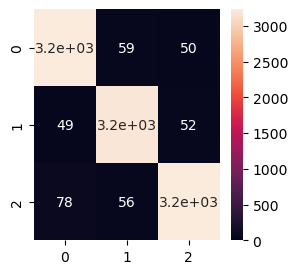

In [109]:
pred_best_cat = optimal_cat.predict(X_train_red)
print(classification_report(y_train, pred_best_cat))

fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix(y_train, pred_best_cat), annot=True, vmin=0, ax=ax)
plt.show()

In [110]:
y_pred_Cat_opt = optimal_cat.predict(X_test_red)

In [111]:
df_pred_Cat_opt = pd.DataFrame()
df_pred_Cat_opt['Id']=X_test_raw['Id']
df_pred_Cat_opt.set_index('Id', inplace=True)
df_pred_Cat_opt['Predicted'] = y_pred_Cat_opt.ravel()

df_pred_Cat_opt.to_csv('../data/raw/df_pred_Cat_opt.csv')

No performance improvement to model_Cat_red